## Lab 2

### Part 1. NN from scratch and MNIST warmup (1 point)

__This part is connected with assignment0_05, you will need to finish it firts. If it is not finished yet, you can work on the next parts.__


Please, go to the `week0_07` directory and fill the `main_notebook.ipynb`. Then hand in the completed notebook.

If you already done that (e.g. while working on assignment0_05), there is small update in there (which requires you to achieve same results with PyTorch network). Update the notebook or read the notebook in the web version.

In [ ]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [ ]:
# (re-)load layers
%run modules.ipynb

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [ ]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((50000, 28, 28), (10000, 28, 28), (10000, 28, 28))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((50000,), (10000,), (10000,))

One-hot encode the labels first.

In [ ]:
# Your code goes here. ################################################
def onehot_encode(y):
    y_unique = np.unique(y)
    n = len(y_unique)
    e = np.eye(n)
    encode = dict([(y_unique[i], e[i]) for i in range(n)])
    return np.array([encode[el] for el in y])
    
y_train = onehot_encode(y_train)
y_val = onehot_encode(y_val)
y_test = onehot_encode(y_test)

In [ ]:
image_size = X_train.shape[1]
input_size = image_size * image_size
input_size

784

In [ ]:
X_train = np.reshape(X_train, [-1, input_size])
X_val = np.reshape(X_val, [-1, input_size])
X_test = np.reshape(X_test, [-1, input_size])

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((50000, 784), (10000, 784), (10000, 784))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((50000, 10), (10000, 10), (10000, 10))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

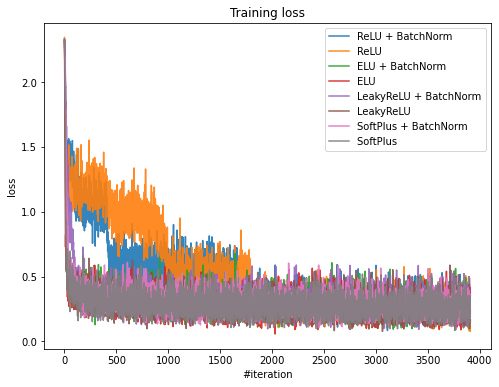

Epoch num: 9 || Avg loss for ReLU + BatchNorm: 0.471 || Time needed: 1.491 sec.
Epoch num: 9 || Avg loss for ReLU            : 0.518 || Time needed: 1.177 sec.
Epoch num: 9 || Avg loss for ELU + BatchNorm: 0.31 || Time needed: 1.244 sec.
Epoch num: 9 || Avg loss for ELU            : 0.286 || Time needed: 1.104 sec.
Epoch num: 9 || Avg loss for LeakyReLU + BatchNorm: 0.32 || Time needed: 1.336 sec.
Epoch num: 9 || Avg loss for LeakyReLU            : 0.289 || Time needed: 1.086 sec.
Epoch num: 9 || Avg loss for SoftPlus + BatchNorm: 0.311 || Time needed: 1.218 sec.
Epoch num: 9 || Avg loss for SoftPlus            : 0.287 || Time needed: 1.084 sec.



In [ ]:
# Your code goes here. ################################################
import time

nets = []

for active_func in [ReLU(), ELU(), LeakyReLU(), SoftPlus()]:
    for batch_norm in [True, False]:
        net = Sequential()
        net.add(Linear(input_size, 10))
        if batch_norm:
            net.add(BatchNormalization(alpha=0.9))
            net.add(ChannelwiseScaling(n_out=10))
        net.add(active_func)
        net.add(LogSoftMax())
        legend = f"{repr(active_func)}" + (f" + BatchNorm" if batch_norm else "            ")
        loss_history = []
        nets.append((net, legend, loss_history))


# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 10
batch_size = 128


criterion = ClassNLLCriterion()
message = ''

for i in range(n_epoch):
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    for net, legend, loss_history in nets:
        start = time.time()
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
            net.zeroGradParameters()
            
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
        
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            
            # Update weights
            sgd_momentum(net.getParameters(), 
                        net.getGradParameters(), 
                        optimizer_config,
                        optimizer_state)      
            
            loss_history.append(loss)
        end = time.time()

        plt.plot(loss_history, label=legend, alpha=0.9)
        message += f'Epoch num: {i} || Avg loss for {legend}: {round(sum(loss_history)/len(loss_history), 3)} || Time needed: {round(end-start, 3)} sec.\n'  

    # Visualize
    plt.legend(loc='upper right')
    plt.show()
    print(message)
    message = ''
    
      

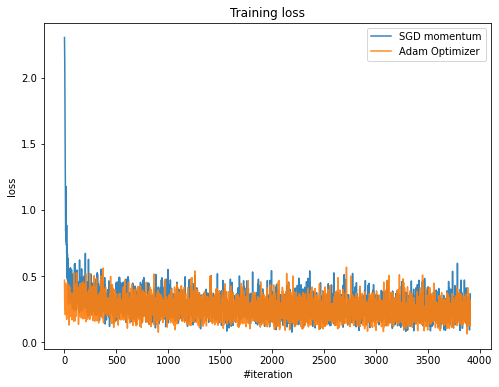

Epoch num: 9 || Avg loss for SGD momentum: 0.278 || Time needed: 1.16 sec.
Epoch num: 9 || Avg loss for Adam Optimizer: 0.25 || Time needed: 1.059 sec.



In [ ]:
net = Sequential()
net.add(Linear(input_size, 10))
net.add(ReLU())
net.add(LogSoftMax())

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

optimizers = []

for optim in [sgd_momentum, adam_optimizer]:
    optimizer_config = {}
    if optim == sgd_momentum:
        optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
        legend = 'SGD momentum'
    else:
        optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
        legend = "Adam Optimizer"
    optimizer_state = {}
    loss_history = []
    optimizers.append((optim, legend, loss_history, optimizer_config, optimizer_state, net))
    

for i in range(n_epoch):
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    for optim, legend, loss_history, optimizer_config, optimizer_state, net in optimizers:
        start = time.time()
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
            net.zeroGradParameters()
            
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
        
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            
            # Update weights
            optim(net.getParameters(), 
                        net.getGradParameters(), 
                        optimizer_config,
                        optimizer_state)      
            
            loss_history.append(loss)
        end = time.time()

        plt.plot(loss_history, label=legend, alpha=0.9)
        message += f'Epoch num: {i} || Avg loss for {legend}: {round(sum(loss_history)/len(loss_history), 3)} || Time needed: {round(end-start, 3)} sec.\n'  

    # Visualize
    plt.legend(loc='upper right')
    plt.show()
    print(message)
    message = ''

**Looks like Adam  is better :)**

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Some point's I found:
- BatchNorm helps loss to converge faster
- BatchNorm doesn't really help on SoftMax and LeakyReLU cases
- Activation functions are cool :)

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

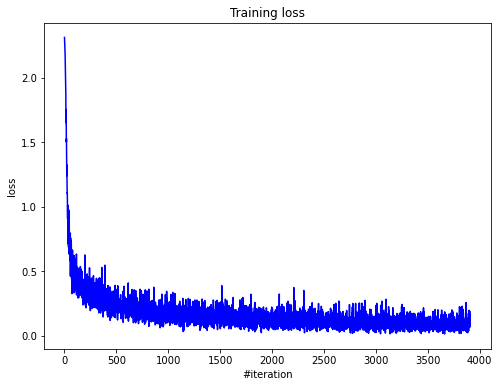

Current loss: 0.160883


In [ ]:
# Your code goes here. ################################################
#### SUPER COOL MODEL ####

cool_net = Sequential()
cool_net.add(Linear(input_size, 256))
cool_net.add(LeakyReLU())
cool_net.add(Dropout())
cool_net.add(Linear(256, 256))
cool_net.add(LeakyReLU())
cool_net.add(Dropout())
cool_net.add(Linear(256, 10))
cool_net.add(SoftMax())

optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
optimizer_state = {}

n_epoch = 10
batch_size = 128


criterion = ClassNLLCriterionUnstable()

loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        cool_net.zeroGradParameters()
        
        # Forward
        predictions = cool_net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        cool_net.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(cool_net.getParameters(), 
                     cool_net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

Print here your accuracy on test set. It should be around 90%.

In [ ]:
# Your answer goes here. ################################################
from sklearn.metrics import accuracy_score
cool_net.evaluate()
y_pred = onehot_encode(np.argmax(cool_net.forward(X_test), axis=1))
accuracy_score(y_test, y_pred)


0.9771

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

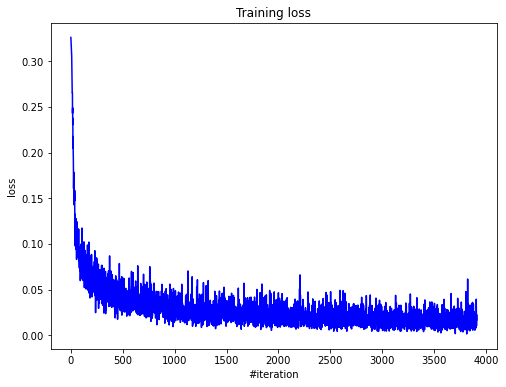

Current loss: 0.016758


In [ ]:
# Your beautiful code here.
import torch.nn as nn
import torch

n_epoch = 10
batch_size = 128

def train_model(X_train, y_train, model):
    optimizer_config = {'lr': 1e-3, 'betas': (0.9, 0.999), 'eps':1e-8}
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), **optimizer_config)
    loss_history = []
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            optimizer.zero_grad()
            yhat = model(torch.from_numpy(x_batch).float())
            loss = criterion(yhat, torch.from_numpy(y_batch).float())
            loss.backward()
            optimizer.step()
            loss_history.append(loss)

        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))
            
        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()
        
        print('Current loss: %f' % loss) 



torch_net = nn.Sequential(
    nn.Linear(input_size, 256),
    nn.LeakyReLU(),
    nn.Dropout(),
    nn.Linear(256, 256),
    nn.LeakyReLU(),
    nn.Dropout(),
    nn.Linear(256, 10),
    nn.Softmax(dim=1)
)

train_model(X_train, y_train, torch_net)

In [ ]:
torch_net.eval()
y_proba = torch_net(torch.from_numpy(X_test)).detach().numpy()
y_pred = onehot_encode(np.argmax(y_proba, axis=1))
accuracy_score(y_test, y_pred)


0.9766